# Facies classification using machine learning
#### Joshua Poirier, [NEOS](https://www.neosgeo.com/)
2016 SEG Machine Learning Competition  

## Introduction

This notebook demonstrates a novel way of training a machine learning algorithm to predict facies from well log data. The data set we use comes from a class exercise from The University of Kansas on Neural Networks and Fuzzy Systems. This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields.  

The data set we will use contains log data from nine wells that have been labeled with a facies type based on core examination. I use this log data to train support vector machine (SVM) classifiers to predict the facies type. SVM's are a type of supervised learning algorithm which can be trained on data to perform classification and regression. The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (in our case - facies). 

My approach is to build multiple models and allow them to **vote** - this process is called **blended modeling**. The novelty in my approach is that I build a model for each well in the training data and weight it based on its cross-correlation with the well of interest. This is intended to re-introduce some spatial geometry to the problem. Wells closer to the well of interest are more likely to exhibit a similar log character. Cross-correlation between close wells should show smaller lag and higher maximum correlation. Furthermore, the lag may be used to pre-process the **RELPOS** (relative position) channel - enhancing the predictive nature of that feature.  

To get started, let's load the libraries and supporting files!

In [27]:
# supporting visualization libraries
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

# libraries and supporting files
library(e1071)
#library(caret)

## 2 Loading and splitting the data  

Blahblahblah

In [2]:
# function to load data
loadData <- function() {
    fname <- "../facies_vectors.csv"
    data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))
    
    data
}

In [4]:
# function to pre-process the data
preProcessData <- function(data) {
    # convert NM_M channel into a binary channel "isMarine"
    data$NM_M <- data$NM_M == "2"
    names(data)[10] <- "isMarine"

    # make the Facies channel more descriptive
    levels(data$Facies) <- c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS")
    
    data
}

In [5]:
# function to split the data
splitData <- function(data, testWell) {
    testIndex <- data$Well.Name == testWell
    
    train <- data[!testIndex,]
    test <- data[testIndex,]
    split <- list(train, test)
    
    split
}

In [6]:
# load and pre-process the data
data <- loadData()
data <- preProcessData(data)

# split the data
split <- splitData(data, "SHANKLE")
train <- split[[1]]
test <- split[[2]]
rm(data, split)

"Training Data"
head(train)

"Testing Data"
head(test)

[1] "Training Data"

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,FALSE,0.957
FSiS,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,FALSE,0.936
FSiS,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,FALSE,0.915
FSiS,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,FALSE,0.894


[1] "Testing Data"

,Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
938,CSiS,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,FALSE,1.000
939,CSiS,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,FALSE,0.984
940,CSiS,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,FALSE,0.968
941,CSiS,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,FALSE,0.952
942,CSiS,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,FALSE,0.935
943,CSiS,A1 SH,SHANKLE,2777.0,82.56,0.599,12.9,13.105,3.5,FALSE,0.919


## 3 Exploratory Data Analysis  

Blahblahblah  

### 3.1 Function building and testing  

To properly perform exploratory data analysis (and subsequent model tuning, training, and testing) we will need to build a few functions. Here, we'll build some functions and test them with simulated data.  

#### 3.1.1 Centering and scaling data  

Centering and scaling data is common practice in machine learning applications.  Considering our well problem, it's no stretch to imagine that the log responses between two wells may be similar; however, they may be offset or have different sensitivities.  This may result from imperfect instrument calibration, different vintages of data, or even geologic noise.  For our problem of predicting facies we want to remove these effects as much as possible.  As such, we center and scale *numeric* data - classification data are not centered or scaled (such as our **isMarine** feature) as that just wouldn't make sense!

In [7]:
# function to center/scale data
centerScaleData <- function(data) {
   
    # we only want to center/scale data which is numeric
    toScale <- sapply(data, class) == "numeric"
    
    # for each numeric feature in the data frame, center and scale
    for (i in 1:length(toScale)) {
        if (toScale[i]) {
            data[,i] <- scale(data[,i])
        }
    }
    
    data
}

Now let's test this function to ensure it's working. I'll simulate some data and apply the function.

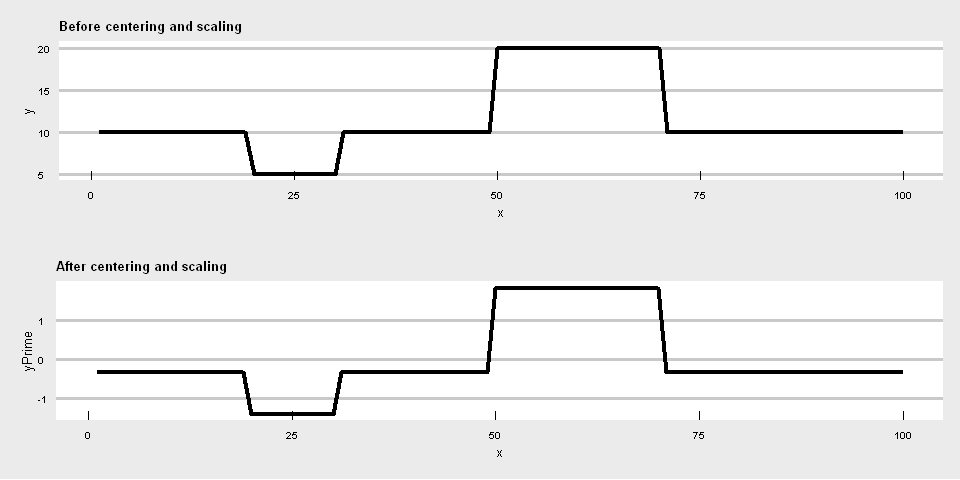

In [8]:
# simulate x and y data
x <- 1:100
y <- rep(10, 100)
y[20:30] <- 5
y[50:70] <- 20

# build data frame with yPrime as the center and scaled 'y' data
simData <- data.frame(x, y, centerScaleData(as.data.frame(y)))
names(simData) <- c("x", "y", "yPrime")

options(repr.plot.width=8, repr.plot.height=4)

# plot before centering and scaling
g1 <- ggplot(simData, aes(x=x, y=y)) + theme_economist_white(gray_bg=T) +
        labs(title="Before centering and scaling") +
        geom_line(size=1.2) +
        theme(axis.text=element_text(size=6), axis.title=element_text(size=8), plot.title=element_text(size=8))

# plot after centering and scaling
g2 <- ggplot(simData, aes(x=x, y=yPrime)) + theme_economist_white(gray_bg=T) +
        labs(title="After centering and scaling") +
        geom_line(size=1.2) +
        theme(axis.text=element_text(size=6), axis.title=element_text(size=8), plot.title=element_text(size=8))

# bring plots together in one figure
g <- plot_grid(g1, g2, ncol=1)
ggdraw() + draw_plot(g, width=1, height=1)

Notice how *after* the centering and scaling the data is centered around **zero** and has a much smaller range compared to *before*. Looks good, now let's move on!  

#### 3.1.2 Cross-correlation  

Cross-correlation measures well two data sets (time series) resemble each other.  If the two sets are offset from each other, they will show **maximum correlation** at that offset, or **lag**.  For our problem, we may be able to exploit cross-correlation to weight the data going into the predictive models. Data from wells closer to the test well are likely to be more predictive than data from wells farther from the test well due to having a similar depositional environment and having undergone similar geologic processes post-deposition.  

We may be able to leverage cross-correlation to come up with a proxy for this similarity.  The **maximum correlation** and **lag** may approximate this similarity.  My thesis in this notebook is that log profiles which are most similar and least offset are most predictive.  

Before we get there, we must build a cross-correlation function and test it!

In [125]:
# function to perform crosscorrelation between two vectors
crossCorrelate <- function(a, b) {

    # calculate cross-correlation between vectors a and b
    ccor <- ccf(a, b, lag.max=400, plot=F)

    # retrieve the maximum correlation and associated lag
    corr <- max(ccor[["acf"]][,,1])
    lag <- ccor[["lag"]][,,1][which.max(ccor[["acf"]][,,1])]
    
    # return maximum correlation and associated lag
    list(correlation=corr, lag=lag)
}

Now let's simulate some data and test the function!  My two 20-pt anomalies will occur 30-pts offset from each other.  Can cross-correlation resolve this?

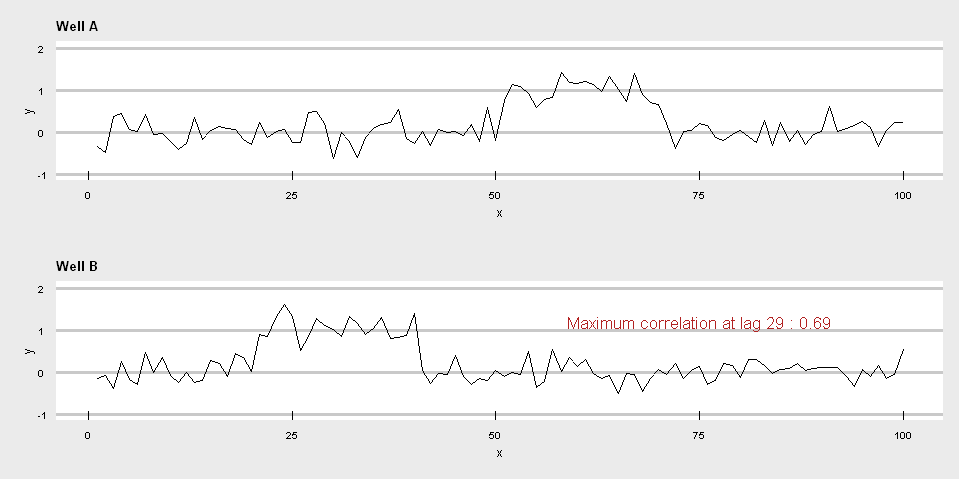

In [179]:
# basic plotting function
plotSimLog <- function(data, plotTitle) {
    g <- ggplot(data, aes(x=x, y=y)) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-1,2)) +
        labs(title=plotTitle) +
        geom_line() +
        theme(axis.text=element_text(size=6), axis.title=element_text(size=8), plot.title=element_text(size=8))
    g
}

set.seed(3124)

# simulate some offset data
a <- c(rep(0, 50), rep(1, 20), rep(0,30)) + rnorm(100,0,.25)
b <- c(rep(0, 20), rep(1, 20), rep(0,60)) + rnorm(100,0,.25)
ccorr <- crossCorrelate(a, b)

# build plots of two simulated wells
options(repr.plot.width=8, repr.plot.height=4)

ga <- plotSimLog(data.frame(x=1:100, y=a), "Well A")
gb <- plotSimLog(data.frame(x=1:100, y=b), "Well B") +
        geom_text(aes(x=75, y=1.2, 
                      label=paste("Maximum correlation at lag", ccorr$lag, ":", round(ccorr$correlation,2)))
                  , size=3.5, col="firebrick")
g <- plot_grid(ga, gb, ncol=1)
ggdraw() + draw_plot(g, width=1, height=1)

There we have it, even with noise added cross-correlation resolves a **lag** of **29** compared to the true offset of 30.  

#### 3.1.3 Looping across features  

It would be useful to have a function which can loop across several features in a pair of data frames and apply a given function.  So let's build one!

In [36]:
# apply a function "FUN" over columns of data frames "a" and "b"
# NOTE: FUN must take two arguments, two vectors of data
loopAcrossFeatures <- function(a, b, features, FUN) {
    
    # get list of columns for a and b dataframes
    features_a <- names(a)[names(a) %in% features]
    features_b <- names(b)[names(b) %in% features]
    
    # ensure a and b data frames have the same features
    try ((if (!all.equal(features_a, features_b)) stop("Error! Data frames do not have the same features.")))
    
    # initialize resulting data frame
    r <- data.frame()
    
    # loop through features
    for (feature in features) {
        # retrieve the feature vector of interest from each data frame
        av <- as.data.frame(a[,which(names(a) %in% feature)])
        bv <- as.data.frame(b[,which(names(b) %in% feature)])
        
        # apply the function to the two features, storing in a data frame
        temp <- as.data.frame(FUN(av, bv))
        temp$feature <- feature
       
        # merge result with those of other features
        r <- rbind(temp,r)
    }
    
    r
}

Now let's test this function by applying our cross-correlation function to a pair of data frames containing simulated data!  The data simulated will have a 20-pt anomaly offset by 30-pt's between the two data sets.

In [37]:
set.seed(456)

# simulate some data
x <- 1:100
a <- c(rep(0,50), rep(1,20),rep(0,30))
b <- c(rep(0,20), rep(1,20),rep(0,60))

# build data frames using simulated data - add increasing amount of noise to 'a' and 'b' vectors as features
df1 <- data.frame(x=x, sm_noise=a+rnorm(100,0,.01), md_noise=a+rnorm(100,0,.1), lg_noise=a+rnorm(100,0,1))
df2 <- data.frame(x=x, sm_noise=b+rnorm(100,0,.01), md_noise=b+rnorm(100,0,.1), lg_noise=b+rnorm(100,0,1))

# loop across the features in the data frame
loopAcrossFeatures(df1, df2, c("sm_noise", "md_noise", "lg_noise"), crossCorrelate)

correlation,Lag,feature
0.2759573,37,lg_noise
0.8603389,30,md_noise
0.9243086,30,sm_noise


Interesting!  This shows two things: A) our function is working, and B) with increasing the noise we get lower correlation and potentially incorrect **lag** (compared to the correct value of 30).  Something to keep in mind during the application of these functions moving forward.  

In [53]:
crossCorrData <- function(train, test, features=c("GR", "ILD_log10", "DeltaPHI", "PHIND", "isMarine")) {
    
    # initialize weights list
    crossCorrs <- data.frame(trainWell=factor(), testWell=factor(), feature=factor(), correlation=numeric(), lag=numeric())
    
    # retrieve list of wells in training set
    trainWells <- unique(train$Well.Name)
    
    # loop through training wells
    for (well_i in trainWells) {
        # subset the data
        train_i <- train[train$Well.Name == well_i,]
        
        # calculate cross-correlation for each feature between current training well and testing well
        temp <- loopAcrossFeatures(centerScaleData(train_i), centerScaleData(test), features, crossCorrelate)
        temp$trainWell <- well_i
        temp$testWell <- test$Well.Name[1]
        
        # add current wells cross-correlation metrics to the data frame
        crossCorrs <- rbind(crossCorrs, temp)
    }
    
    crossCorrs
}

In [42]:
buildPlot <- function(data, plotTitle) {

    # build correlation plot
    gc <- ggplot(data, aes(feature, trainWell, fill=correlation)) + theme_economist_white(gray_bg=T) +
            geom_raster(alpha=.8) +
            labs(x="", y="Well", title=plotTitle) +
            scale_fill_distiller(palette="Spectral", name="", direction=-1, lim=c(0.15, 0.8)) +
            theme(legend.position="right",
                  plot.title=element_text(size=8), 
                  axis.text=element_text(size=6),
                  axis.text.x=element_text(size=6, angle=90),
                  axis.title=element_text(size=8),
                  legend.text=element_text(size=8))
    
    # return the plots
    gc
}

### 3.2 Cross-correlation by feature  

Different features (**GR**, **ILD_log10**, etc.) may exhibit different cross-correlation results.  I'll now loop through the training data wells and treat each iterated well as the *test* well.  We'll apply cross-correlation with the remaining wells and average their peak correlations to see which features are most correlative.  

We will also (temporarily) discard the **Recruit F9** *well*.  This data does not represent an actual well; rather, curated data points for the facies **Phylloid-algal bafflestone** - so we'll treat it specially later.

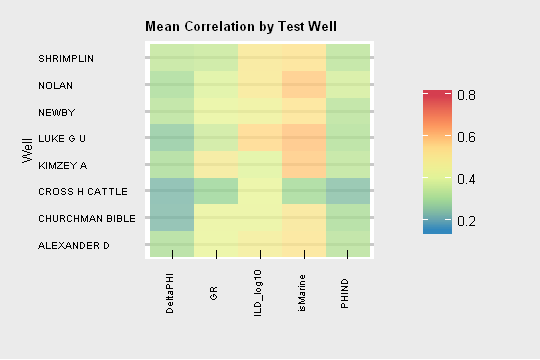

In [52]:
trainLoop <- train[train$Well.Name != "Recruit F9",]
wells <- unique(trainLoop$Well.Name)

for (well_i in wells) {
    split <- splitData(trainLoop, well_i)
    atrain <- split[[1]]
    atest <- split[[2]]
    
    weights <- rbind(weights, crossCorrData(atrain, atest))
}

agg <- aggregate(correlation ~ feature + testWell, data=weights, FUN=mean)
names(agg) <- c("feature", "trainWell", "correlation")

options(repr.plot.width=4.5, repr.plot.height=3)
plt <- buildPlot(agg, "Mean Correlation by Test Well")
plt

From this, we see that the **isMarine** feature appears most correlative between wells followed by **ILD_log10**.  Since this is an aggregate plot, let's break this up to be thorough and look at the correlations for each well against the others for each feature. Similarly, the **CROSS H CATTLE** well appears to consistently have poorer correlation than other wells.  If we were trying to predict values from any other well, it would be logical to weight this wells data lower than the others!

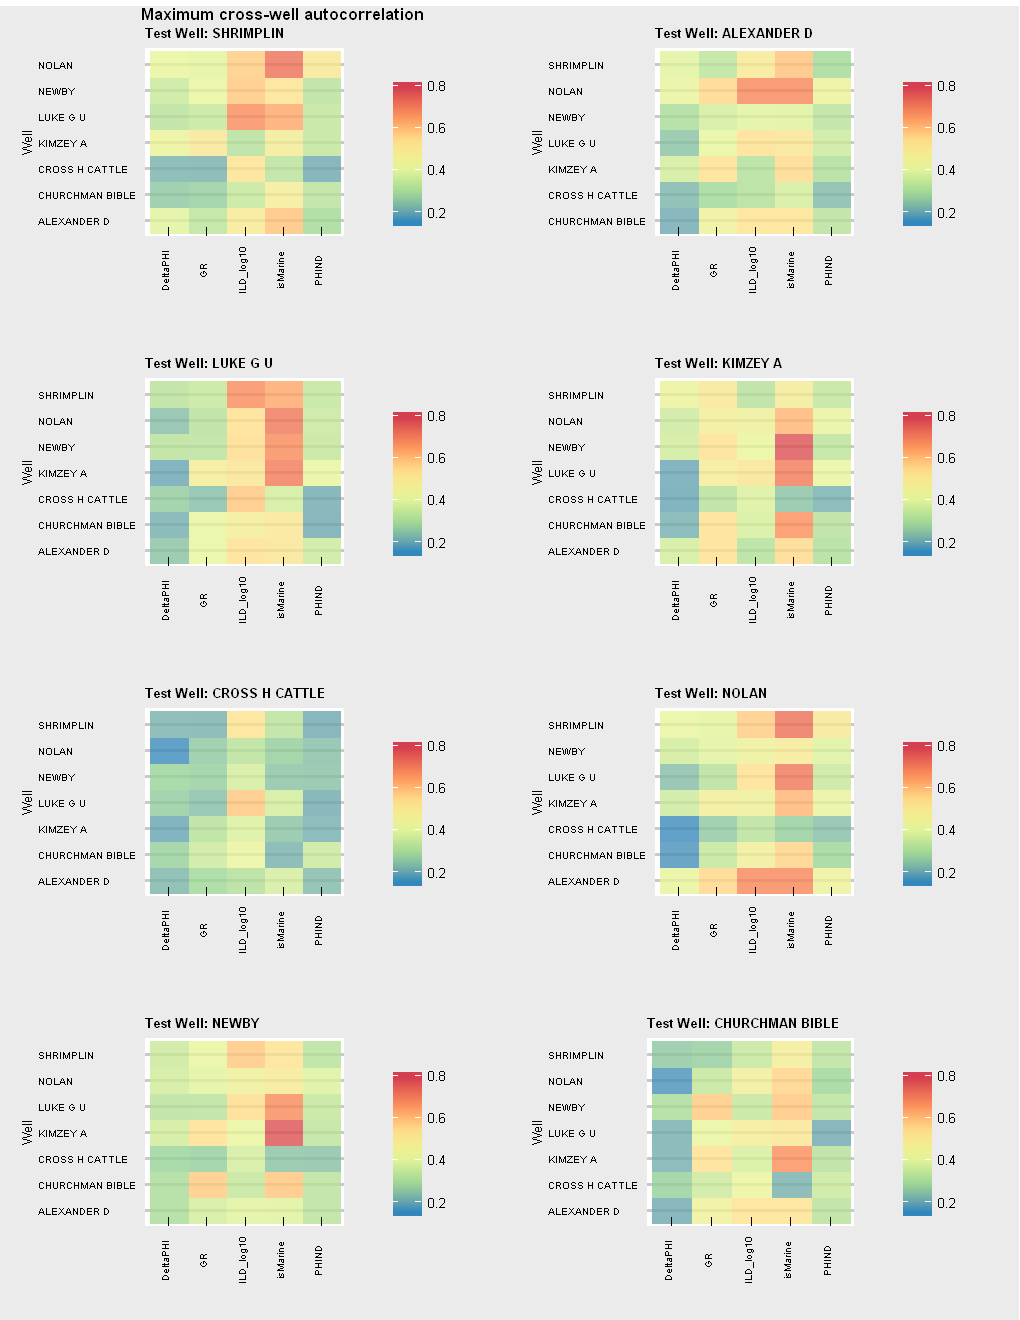

In [47]:
lagPlots <- list()
corrPlots <- list()

wells <- unique(weights$testWell)

for (well_i in wells) {
    subset <- weights[weights$testWell == well_i,]
    corrPlots[[well_i]] <- buildPlot(subset, paste("Test Well:", well_i))
}

options(repr.plot.width=8.5, repr.plot.height=11)
g <- do.call(plot_grid, c(corrPlots, ncol=2))
ggdraw() + draw_plot(g, width=1, height=1, y=-.005) + draw_plot_label("Maximum cross-well autocorrelation", size=10)

Looking more thoroughly at the data shows similar patterns as previously discussed.  The **isMarine** and **ILD_log10** features correlate strongest and the **CROSS H CATTLE** well is notably less correlative with the remaining wells.  

### 3.3 Build a basic model  

Now let's start doing some actual model building!  First I'll partition the data and use the **SHRIMPLIN** well as the test data, the remaining wells will act as training data.  

#### 3.3.1 Training a blended model  

Blended modeling is a practice where many models are built - and in the regression case averaged.  Our application is classification of **Facies** - so each model votes on a classification.  The classification with the most votes is assigned.  

For our application, we will build a predictive model for each well in the training set. The function which follows takes in the training data and returns a predictive model for each well in that training set.

In [197]:
trainBlendedModel <- function(data, cost, gamma) {

    # initialize model and params
    fits <- list()
    
    # retrieve list of wells in data set
    wells <- unique(data$Well.Name)
    
    # loop through wells
    for (well_i in wells) {
        # subset the data
        data_i <- data[data$Well.Name == well_i,-2]
        
        # build the model for this well
        fits[[well_i]] <- svm(Facies ~ ., data=data_i, kernel='radial', cost=cost, gamma=gamma)
    }
    
    fits
}

#### 3.3.2 Weight a blended model  

blahblahblah

In [172]:
weightModel <- function(wells, lags, corrs, p) {
    # we want small lags and high correlations, so scale accordingly
    data <- data.frame(well=wells, lagscaled=lags/max(lags), corrscaled=(1-corrs))
    data$lag <- lags
    data$corr <- corrs
    
    # calculate the inverse distance weighting
    # distance is calculated in lag-correlation data space
    data$weight <- ((data$lagscaled^2 + data$corrscaled^2)^2)^(-p)
    
    # return well list and their respective model weights
    data[,-c(2,3)]
}

weightBlendedModel <- function(train, test, 
                               features=c("GR", "ILD_log10", "DeltaPHI", "PHIND", "isMarine"),
                               method="maxCorr",
                               p=1) {
    
    # cross-correlate the test well with the training wells
    cc <- crossCorrData(train, test, features)
    
    # aggregate the cross-correlation results
    if (method == "maxCorr") {
        r <- data.frame()
        aggMax <- aggregate(correlation~trainWell, cc, FUN=max)
        trainWells <- unique(agg$trainWell)
        for (well_i in trainWells) {
            r <- rbind(r, cc[cc$trainWell == well_i & cc$correlation == aggMax$correlation[which(aggMax$trainWell==well_i)],])
        }        
    } else if (method == "singleFeature") {
        r <- cc[cc$feature=="isMarine",]
    } else if (method == "mean") {
        r <- aggregate(cbind(lag,correlation)~trainWell,data=cc,FUN=mean)    
    } else {
        r <- aggregate(cbind(lag, correlation)~trainWell, data=cc, FUN=median)
    }

    # calculate a weighting
    weightModel(r$trainWell, r$lag, r$correlation, p)
}

#### 3.3.3 Build a blended model  

Our blended model is essentially defined by the two previous functions.  Here we combine them into a single function object.

In [191]:
buildBlendedModel <- function(train, test, features, cost, gamma) {
    # initialize the blended model
    blendedModel <- list()
    
    # train and weight the models
    blendedModel[["fits"]] <- trainBlendedModel(train, cost, gamma)
    blendedModel[["weights"]] <- weightBlendedModel(train, test, method="singleFeature")
    
    # return the blended model
    blendedModel
}

Now let's build a blended model.  For this example, we'll use **SHRIMPLIN** as our test well and the remaining training wells for training.

In [198]:
trainLoop <- train[train$Well.Name != "Recruit F9",]
wells <- unique(trainLoop$Well.Name)

split <- splitData(trainLoop, "SHRIMPLIN")
atrain <- split[[1]]
atest <- split[[2]]

#weightBlendedModel(atrain, atest, method="singleFeature")
blendedModel <- buildBlendedModel(atrain[,-c(2,4,9)], atest[,-c(2,4,9)], cost=10, gamma=1)

But we haven't predicted anything yet.  In fact, we haven't even built our prediction function yet!  So let's build a function which takes in a blended model and test data - and predict the **facies**.

In [199]:
predictBlendedModel <- function(test, blendedModel) {
    predictions <- list()
    wells <- names(blendedModel[["fits"]])
    
    for (well_i in wells) {
        fit <- blendedModel[["fits"]][[well_i]]
        print(fit)
        predictions[[well_i]] <- predict(fit, newdata=test)
    }
    
    predictions
}

predictBlendedModel(atest, blendedModel)


Call:
svm(formula = Facies ~ ., data = data_i, kernel = "radial", cost = cost, 
    gamma = gamma)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 
      gamma:  1 

Number of Support Vectors:  328


Call:
svm(formula = Facies ~ ., data = data_i, kernel = "radial", cost = cost, 
    gamma = gamma)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 
      gamma:  1 

Number of Support Vectors:  298


Call:
svm(formula = Facies ~ ., data = data_i, kernel = "radial", cost = cost, 
    gamma = gamma)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 
      gamma:  1 

Number of Support Vectors:  358


Call:
svm(formula = Facies ~ ., data = data_i, kernel = "radial", cost = cost, 
    gamma = gamma)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 
      gamma:  1 

Number of Support Vectors:  332


Call:
svm(formula = Facies ~ ., data = data_i, kern

$`ALEXANDER D`
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS CSiS CSiS CSiS CSiS 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
CSiS CSiS CSiS CSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS CSiS FSiS FSiS CSiS 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
FSiS CSiS   PS   PS CSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS   WS   WS   PS   PS 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
  PS   PS   PS   PS   WS   WS   WS   MS   MS   WS   WS   WS   WS   WS   WS   WS 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
  WS   MS   WS   PS   PS   PS   PS   PS   PS   WS   WS   WS   WS   WS   WS   PS 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
  PS   PS   PS   PS   PS   WS SiSh SiSh   PS   PS   PS   PS   PS   WS   PS   PS 
  97   98   99  100  101  102  103  104  105  106  107  108  109  110  111  112 
  PS FSiS FSiS FSiS FSiS FSiS CSiS FSiS FSiS FSiS CSiS CSiS FSiS FSiS FSiS CSiS 
 113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128 
CSiS CSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS CSiS CSiS FSiS FSiS 
 129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144 
CSiS CSiS CSiS FSiS   PS   PS   WS   WS   WS   PS   PS   PS   PS   PS   PS   PS 
 145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160 
  PS   PS   PS   PS   PS   PS   PS FSiS FSiS FSiS FSiS FSiS FSiS FSiS CSiS FSiS 
 161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176 
FSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS FSiS   PS 
 177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192 
  PS   PS   PS   WS   WS   WS   WS   PS   PS   PS   PS   WS   WS   WS   WS   PS 
 193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208 
  PS   PS CSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS CSiS CSiS CSiS CSiS CSiS 
 209  210  211  212  213  214  215  216  217  218  219  220  221  222  223  224 
CSiS CSiS CSiS CSiS CSiS CSiS CSiS FSiS CSiS CSiS CSiS CSiS CSiS FSiS FSiS   PS 
 225  226  227  228  229  230  231  232  233  234  235  236  237  238  239  240 
  PS   PS   PS   PS   WS   WS   WS   WS   WS   WS   WS   PS CSiS FSiS FSiS CSiS 
 241  242  243  244  245  246  247  248  249  250  251  252  253  254  255  256 
CSiS CSiS CSiS CSiS CSiS CSiS FSiS CSiS CSiS CSiS CSiS FSiS FSiS FSiS FSiS FSiS 
 257  258  259  260  261  262  263  264  265  266  267  268  269  270  271  272 
FSiS FSiS CSiS CSiS CSiS FSiS FSiS FSiS FSiS   PS   PS   WS    D   PS   PS   PS 
 273  274  275  276  277  278  279  280  281  282  283  284  285  286  287  288 
  PS   PS CSiS CSiS CSiS CSiS FSiS FSiS FSiS FSiS CSiS CSiS CSiS CSiS CSiS CSiS 
 289  290  291  292  293  294  295  296  297  298  299  300  301  302  303  304 
FSiS   PS   PS   PS   PS   PS   PS   WS   WS   WS   WS   WS   WS   PS   PS   PS 
 305  306  307  308  309  310  311  312  313  314  315  316  317  318  319  320 
  PS   WS   WS   WS   WS FSiS   PS   PS FSiS FSiS FSiS FSiS FSiS FSiS FSiS FSiS 
 321  322  323  324  325  326  327  328  329  330  331  332  333  334  335  336 
FSiS FSiS FSiS FSiS FSiS FSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS 
 337  338  339  340  341  342  343  344  345  346  347  348  349  350  351  352 
CSiS CSiS CSiS CSiS CSiS CSiS CSiS FSiS FSiS FSiS FSiS FSiS CSiS CSiS CSiS CSiS 
 353  354  355  356  357  358  359  360  361  362  363  364  365  366  367  368 
CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS CSiS FSiS FSiS FSiS 
 369  370  371  372  373  374  375  376  377  378  379  380  381  382  383  384 
  WS   WS   WS   WS   PS   PS   PS   PS   WS   PS   PS   PS   PS   WS   WS   WS 
 385  386  387  388  389  390  391  392  393  394  395  396  397  398  399  400 
  WS    D    D  

## Model tuning  

Blahblahblah

In [4]:
# function to tune model
tuneBlendedModel <- function(data, features) {
    
    # retrieve list of wells in data set
    wells <- unique(data$Well.Name)
    
    # loop through wells
    for (well_i in wells) {
        # split data into training and test (well_i is test)
        split <- splitData(data, well_i)
        atrain <- split[[1]]
        atest <- split[[2]]
        
        # build blended model using training data
        buildBlendedModel(atrain, atest, features, 10, 1)
    }
}

In [5]:
# execute model tuning, print the model tuning parameters

## Training  

Blahblahblah

In [6]:
# function to train model

In [7]:
# execute model training

## Testing  

Blahblahblah

In [8]:
# function to test model (on SHANKLE well)

In [9]:
# execute model testing

## Conclusions  

Blahblahblah